In [106]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.models as models
import torchvision.transforms as transforms

import copy

img1 = "./dancing.jpg"
img2 = "./picasso.jpg"

In [189]:
content_layers_default = ["conv_4"]
style_layers_default = ["conv_1", "conv_2", "conv_3", "conv_4", "conv_5"]

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

def gram_matrix(input):
    b, c, h, w = input.size()
    features = input.view(b, c, h * w)
    G = torch.bmm(features, features.transpose(1, 2))
    return G.div(c * h * w)


def print_hi(name):
    print(f'{name}')
    # Press Ctrl+F8 to toggle the breakpoint.

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.01)

def get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img, content_layers=content_layers_default, style_layers=style_layers_default):
    normalization = Normalization(normalization_mean, normalization_std)
    content_losses = []
    style_losses = []
    model = nn.Sequential(normalization)
    i=0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = "conv_{}".format(i)
        elif isinstance(layer, nn.ReLU):
            name = "relu_{}".format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = "pool_{}".format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = "bn_{}".format(i)
        else:
            raise RuntimeError("Unrecognized Layer: {}".format(layer.__class__.__name__))
        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    return model, style_losses, content_losses

def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std, content_img, style_img, input_img, num_steps=1500, style_weight=35000000, content_weight=1):
    print("Building the style transfer model")
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img)
    input_img.requires_grad_(True)
    model.eval()
    model.requires_grad_(False)
    optimizer = get_input_optimizer(input_img)
    print("Optimizing...")
    run = [0]
    while run[0] <= num_steps:

        def closure():
            with torch.no_grad():
                input_img.clamp(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()
            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print("Style Loss : {:.4f} Content Loss: {:.4f}".format(style_score.item(), content_score.item()))
                print()
            return style_score + content_score
        optimizer.step(closure)
    with torch.no_grad():
        input_img.clamp(0, 1)
    return input_img
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

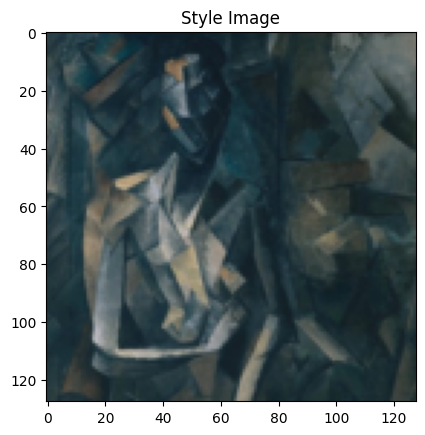

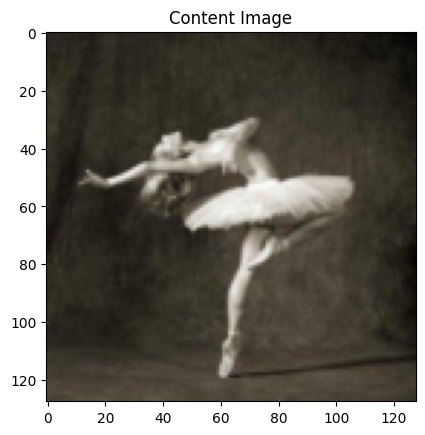

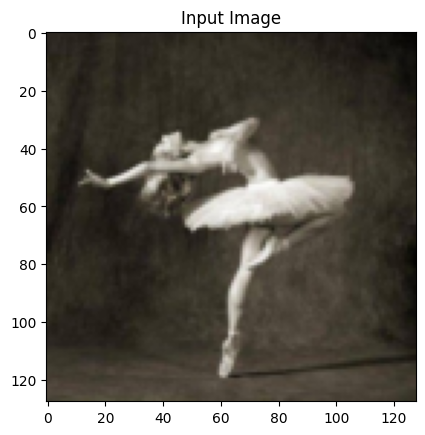

Initialization completed.
Building the style transfer model
Optimizing...
run [50]:
Style Loss : 1674.8506 Content Loss: 10.4637

run [100]:
Style Loss : 262.9383 Content Loss: 10.7903

run [150]:
Style Loss : 110.0576 Content Loss: 11.6306

run [200]:
Style Loss : 66.8360 Content Loss: 12.0866

run [250]:
Style Loss : 47.0697 Content Loss: 12.3347

run [300]:
Style Loss : 35.9092 Content Loss: 12.4935

run [350]:
Style Loss : 28.8485 Content Loss: 12.6229

run [400]:
Style Loss : 24.0769 Content Loss: 12.6948

run [450]:
Style Loss : 20.9264 Content Loss: 12.7457

run [500]:
Style Loss : 18.6697 Content Loss: 12.7740

run [550]:
Style Loss : 16.8964 Content Loss: 12.7804

run [600]:
Style Loss : 15.6222 Content Loss: 12.7832

run [650]:
Style Loss : 14.5753 Content Loss: 12.7840

run [700]:
Style Loss : 13.7535 Content Loss: 12.7822

run [750]:
Style Loss : 13.0564 Content Loss: 12.7771

run [800]:
Style Loss : 12.4762 Content Loss: 12.7690

run [850]:
Style Loss : 11.9979 Content Los

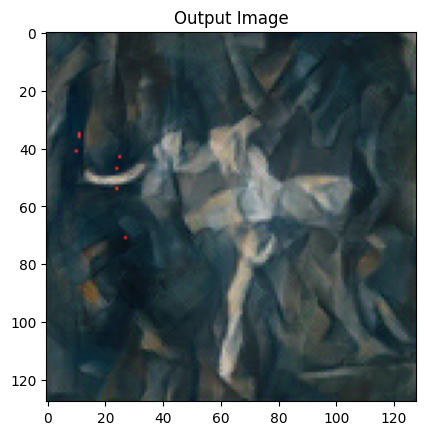

In [190]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
imsize = 128
loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])
style_img = image_loader(img2)
content_img = image_loader(img1)
assert style_img.size() == content_img.size()#, \
unloader = transforms.ToPILImage()
plt.ion()
plt.figure()
imshow(style_img, title="Style Image")
plt.figure()
imshow(content_img, title="Content Image")
input_img = content_img.clone()
plt.figure()
imshow(input_img, title="Input Image")

cnn = models.vgg19(pretrained=True).features.eval()
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])
print_hi('Initialization completed.')

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img)
plt.figure()
imshow(output, title="Output Image")
plt.ioff()
plt.show()